<a href="https://colab.research.google.com/github/josh-millar/josh-millar/blob/main/jnm_diss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pre-processing functions:

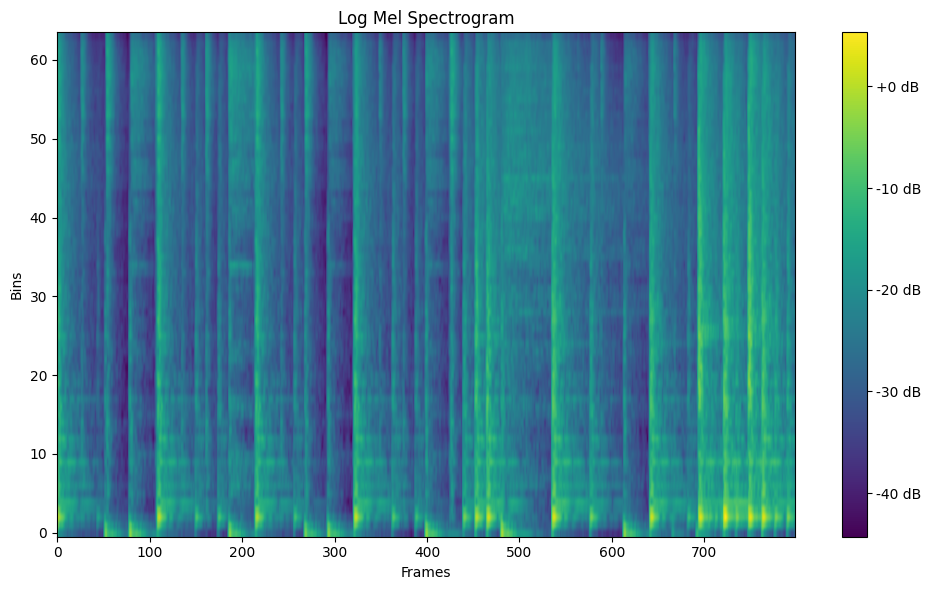

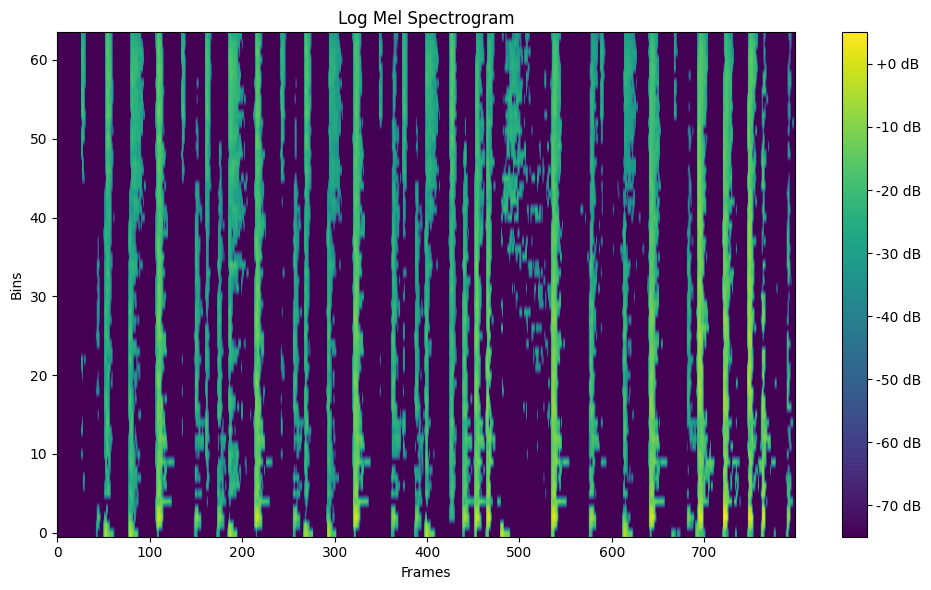

(2, 64, 799)


In [43]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

def resample_audio(audio_path, output_sr, take_chunk=True):
    audio, sr = librosa.load(audio_path, sr=None)
    audio_resampled = librosa.resample(audio, orig_sr=sr, target_sr=output_sr)
    peak_value = np.max(np.abs(audio_resampled))
    normalized_audio = audio_resampled / peak_value
    # choose an 8s chunk
    chunk_seconds = 8 #s
    chunk_size = output_sr * chunk_seconds
    if take_chunk:
        normalized_audio = normalized_audio[chunk_size:2*chunk_size]
    display(Audio(data=normalized_audio, rate=output_sr))
    return normalized_audio

def get_inputs(audio, n_fft, hop_size, n_bins, f_min, sr):
    # logf-stft:
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_size)
    S = np.abs(stft)
    # group the linear bins into log-spaced bins
    f_max = sr / 2
    filter_bank = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_bins, fmin=f_min, fmax=f_max)
    mel_S = np.dot(filter_bank, S)
    log_mel_S = librosa.power_to_db(mel_S)
    # fig, ax = plt.subplots()
    # img = librosa.display.specshow(filter_bank, x_axis='linear', ax=ax)
    # fig.colorbar(img, ax=ax)
    # plt.show()

    # logf-onset: get onsets by compute difference function between current frame
    # and previous 22 frames
    n_previous_frames = 22
    onsets = np.zeros_like(mel_S)

    for frame in range(mel_S.shape[1]):
        if frame > n_previous_frames:
            avg = np.mean(mel_S[:, frame-n_previous_frames:frame], axis=1)
            onsets[:, frame] = mel_S[:, frame] - avg
    # apply half-wave rectification by removing negative values
    onsets = np.max([np.zeros_like(onsets), onsets], axis=0)
    log_onsets = librosa.power_to_db(onsets)

    # concat
    inputs = np.stack([log_mel_S, log_onsets])
    return log_mel_S, log_onsets, inputs

def plot_spectrogram(S):
    plt.figure(figsize=(10, 6))
    plt.imshow(S, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log Mel Spectrogram')
    plt.xlabel('Frames')
    plt.ylabel('Bins')
    plt.tight_layout()
    plt.show()

audio_path = '53_rock_135_beat_4-4_8.n.wav'
audio_path = '64_funk_112_beat_4-4_1.mp3'
output_sr = 22050
audio_resampled = resample_audio(audio_path, output_sr)
n_fft = 1024
hop_size = 221
n_bins = 64
f_min = 40
log_mel_S, log_onsets, inputs = get_inputs(audio_resampled, n_fft, hop_size, n_bins, f_min, output_sr)
plot_spectrogram(log_mel_S)
plot_spectrogram(log_onsets)
print(inputs.shape)